Copyright (c) 2015, 2016 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book

[MIT License](https://github.com/rasbt/python-machine-learning-book/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 10 - Predicting Continuous Target Variables with Regression Analysis 
# 회귀분석에 의한 연속형 목표변수 예측 

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka" -u -d -v -p numpy,pandas,matplotlib,sklearn,seaborn

Sebastian Raschka 
last updated: 2017-09-22 

CPython 3.5.3
IPython 6.2.0

numpy 1.13.1
pandas 0.20.1
matplotlib 2.0.2
sklearn 0.18.2
seaborn 0.8.0


### Overview

- [10.1 Introducing a simple linear regression model](#10.1-Introducing-a-simple-linear-regression-model)
- (심플 선형회귀 모델 소개)
- [10.2 Exploring the Housing Dataset](#10.2-Exploring-the-Housing-dataset)
- (하우징 데이터 탐색)
  - [10.2.1 Visualizing the important characteristics of a dataset](#10.2.1-Visualizing-the-important-characteristics-of-a-dataset)
  - (데이터의 주요 특성 시각화)
- [10.3 Implementing an ordinary least squares linear regression model](#10.3-Implementing-an-ordinary-least-squares-linear-regression-model)
- (순위형 최소 제곱 선형회귀 모델 구현)
  - [10.3.1 Solving regression for regression parameters with gradient descent](#10.3.1-Solving-regression-for-regression-parameters-with-gradient-descent)
  - (그래디언트 디센트를 갖는 회귀 파라미터를 위해 회귀 모델 풀기)
  - [10.3.2 Estimating the coefficient of a regression model via scikit-learn](#10.3.2-Estimating-the-coefficient-of-a-regression-model-via-scikit-learn)
  - (사이킷런을 활용한 회귀 모델 계수 추정)
- [10.4 Fitting a robust regression model using RANSAC](#10.4-Fitting-a-robust-regression-model-using-RANSAC)
- (RANSAC을 사용하는 강건한 회귀 모델 피팅)
- [10.5 Evaluating the performance of linear regression models](#10.5-Evaluating-the-performance-of-linear-regression-models)
- (선형회귀 모델의 성능 평가)
- [10.6 Using regularized methods for regression](#10.6-Using-regularized-methods-for-regression)
- (회귀를 위한 정규화 메서드 사용)
- [10.7 Turning a linear regression model into a curve - polynomial regression](#10.7-Turning-a-linear-regression-model-into-a-curve---polynomial-regression)
- (선형회귀 모델을 곡선의 다항 회귀로 변환하기)
  - [10.7.1 Modeling nonlinear relationships in the Housing Dataset](#10.7.1-Modeling-nonlinear-relationships-in-the-Housing-Dataset)
  - (하우징 데이터 내의 비선형관계 모델링)
  - [10.7.2 Dealing with nonlinear relationships using random forests](#10.7.2-Dealing-with-nonlinear-relationships-using-random-forests)
  - (랜덤 포레스트를 사용하여 비선형관계 처리하기)
    - [10.7.2.1 Decision tree regression](#10.7.2.1-Decision-tree-regression)
    - (의사결정나무 회귀)
    - [10.7.2.2 Random forest regression](#10.7.2.2-Random-forest-regression)
    - (랜덤 포레스트 회귀)
- [10.8 Summary](#10.8-Summary)

- 데이터의 탐색과 시각화 
- 선형회귀 모델의 구현을 위한 여러가지 방법 살펴보기 
- 이상치에 강건한 회귀 모델 훈련하기 
- 회귀 모델 평가와 일반적인 문제 진단 
- 비선형 데이터에 회귀 모델 피팅하기 


In [76]:
from IPython.display import Image
%matplotlib inline

In [3]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
import pandas as pd

# 10.1 Introducing a simple linear regression model 
# 심플 선형회귀 모델 소개 

심플(단변량, univariate) 선형회귀의 목표는 단일 피처(설명변수 $x$)와 연속형 반응 값(목표변수 $y$) 간의 관계를 모델링하는 것이다. 
우리의 목표는 설명변수와 목표변수 간의 관계를 설명하기 위해 선형방정식의 가중치를 학습하여 훈련 데이터의 일부가 아니었던 새로운 설명변수의 반응을 예측하는 데 사용하는 것이다. 

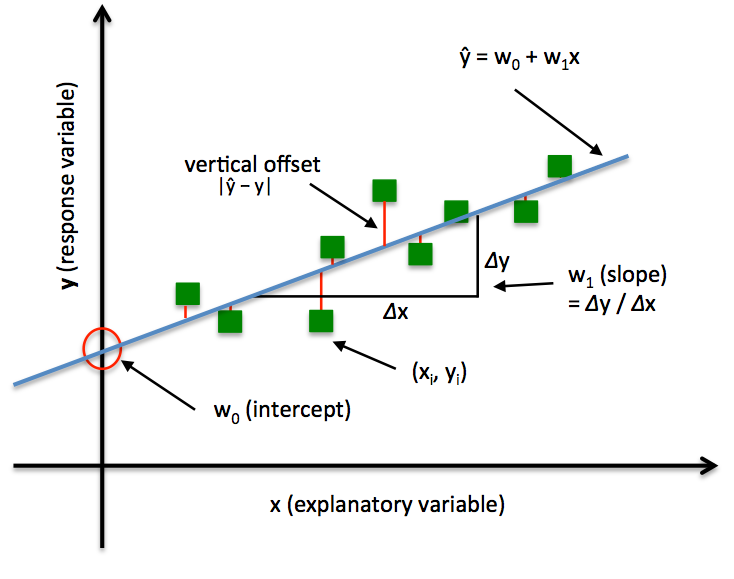

In [4]:
Image(filename='./images/10_01.png', width=500)

최적-피팅 직선 역시 회귀선이라고 하며, 회귀선에서 샘플 관측치들까지의 수직선을 오프셋(offsets) 또는 잔차(residuals)라고 부른다(예측에 대한 오차). 

<br>
<br>

# 10.2 Exploring the Housing dataset 
# 하우징 데이터 탐색 

1978년에 해리슨 박사(D.Harrison)와 L.루빈펠트 박사(D.L.Rubinfeld)가 수집한 보스턴 외곽 집들에 대한 정보를 포함하고 있다. 

Source: [https://archive.ics.uci.edu/ml/datasets/Housing](https://archive.ics.uci.edu/ml/datasets/Housing)

Attributes:
    
<pre>
1. CRIM      per capita crime rate by town 
             자치시별 1인당 범죄율
2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft. 
             25,000평방피트를 초과하는 거주지역의 비율
3. INDUS     proportion of non-retail business acres per town 
             비소매상업지역이 점유하고 있는 토지의 비율 
4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
             찰스강에 대한 더미 변수(강의 경계 위치이면 1, 아니면 0)
5. NOX       nitric oxides concentration (parts per 10 million) 
             10ppm당 일산화질산 농도 
6. RM        average number of rooms per dwelling 
             주택 1가구당 평균 방의 개수 
7. AGE       proportion of owner-occupied units built prior to 1940 
             1940년 이전에 걱축된 소유 주택의 비율 
8. DIS       weighted distances to five Boston employment centres 
             5개 보스턴 직업센터까지의 접근성 
9. RAD       index of accessibility to radial highways 
             방사형 고속도로까지의 접근성에 대한 지표 
10. TAX      full-value property-tax rate per $10,000 
             10,000달더당 재산세율 
11. PTRATIO  pupil-teacher ratio by town
             자치시별 학생/교사 비율 
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
             여기서 Bk는 자치시별 흑인 비율 
13. LSTAT    % lower status of the population 
             모집단의 하위계층의 비율(%) 
14. MEDV     Median value of owner-occupied homes in $1000's 
             본인 소유의 주택가격(중앙값) (단위: 1,000달러) 
</pre>

In [5]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/python-machine-learning-book/master/code/datasets/housing/housing.data',
                  header=None, sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


<hr>

### Note:


If the link to the Housing dataset provided above does not work for you, you can find a local copy in this repository at [./../datasets/housing/housing.data](./../datasets/housing/housing.data).

Or you could fetch it via

In [7]:
df = pd.read_csv('./../datasets/housing/housing.data',
                  header=None, sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


<br>
<br>

## 10.2.1 Visualizing the important characteristics of a dataset 
## 데이터의 주요 특성 시각화 

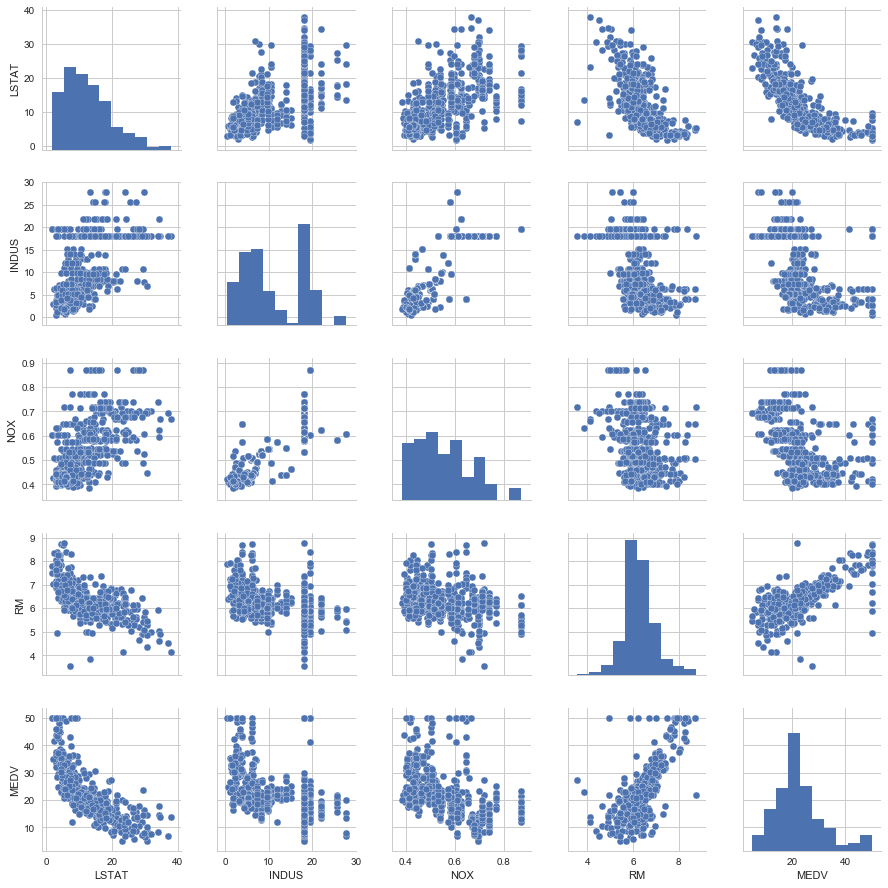

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
# plt.savefig('./figures/scatter.png', dpi=300)
plt.show()

피처 간 선형관계를 수량화하기 위해 이제 상관행렬을 생성하려고 한다. 
직관적으로 상관행렬은 공분산행렬이 재조정된 버전으로 이해할 수 있다. 
사실, 상관행렬은 표준화 데이터로 계산한 공분산행렬과 같다. 

상관행렬은 피어슨곱-모멘트 상관계수(Person product-moment correlation coefficients, Pearson's으로 표기되기도 함)를 포함하는 제곱행렬이다. 
이것은 피처쌍 간의 선형 의존성을 측정한다. 
상관계수는 -1과 1 사이의 범위에 존재한다. 

$r$=1 이면 두 피처는 완전한 양의 상관관계를 갖는 것이며, $r$=-1이면 두 피처는 완전한 음의 상관관계를 갖는 것이다. 
피어슨 상관계수는 두 피처 $x$와 $y$ 간의 공분산(분자)을 $x$와 $y$의 표준편자의 곱(분모)으로 나눔으로써 계산할 수 있다. 

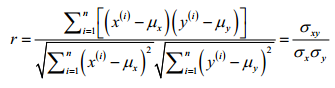

In [9]:
Image(filename='./images/10_21.png', width=400) 

여기서 $\mu$는 피처에 대한 샘플 평균, $\sigma_{xy}$은 피처 $x$와 $y$ 간의 공분산, 그리고 $\sigma_x$와 $\sigma_y$는 각각 피처의 표준편차를 가리킨다.

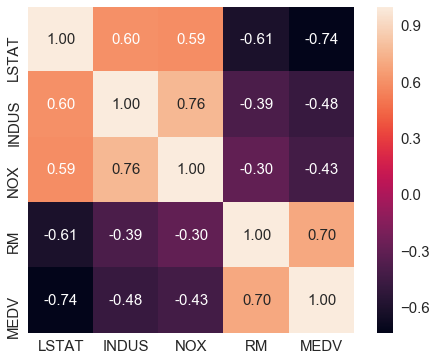

In [10]:
import numpy as np

plt.figure(figsize=(8.0, 6.0))

cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

# plt.tight_layout()
# plt.savefig('./figures/corr_mat.png', dpi=300)
plt.show()

- 목표변수 MEDV는 LSTAT 변수와 가장 큰 상관관계(-0.74)를 갖는다는 것을 알 수 있다.
- 하지만, LSTAT와 MEDV 간에 분명한 비선형관계가 있었던 산점도 행렬을 기억할 것이다.
- 이와 반대로 RM과 MEDV 간의 상관관계는 상대적으로 높고(0.70), 산점도에서 관찰했던 두 변수 간의 선형관계에서 RM은 설명변수로는 탁월한 선택인 것으로 보인다.

In [11]:
sns.reset_orig()
%matplotlib inline

<br>
<br>

# 10.3 Implementing an ordinary least squares linear regression model
# 순위형 최소 제곱 선형회귀 모델 구현

회귀선의 파라미터들의 추정하기 위해 샘플의 관측치들까지의 수직 거리의 제곱합을 최소화하는 순위형 최소제곱(Ordinary Least Square, OLE) 방법을 사용해서 퍼즐의 잃어버린 조각을 채워보도록 하자

## 10.3.1 Solving regression for regression parameters with gradient descent 
## 그래디언트 디센트를 갖는 회귀 파라미터를 위해 회귀 모델 풀기 

In [12]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

하우징 데이터의 RM변수(방의 개수)를 설명변수로 사용하고 MEDV(집의 가격)을 예측할 수 있는 모델을 훈련해보자. 

In [13]:
X = df[['RM']].values
y = df['MEDV'].values

In [14]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [15]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

그래디언트 디센트와 같은 최적화 알고리즘을 사용할 때 수렴을 확인하기 위해 비용을 에포크 수(number of epochs, 훈련하는 횟수)에 관한 함수를 플로팅해 보는 것은 좋은 생각이다.

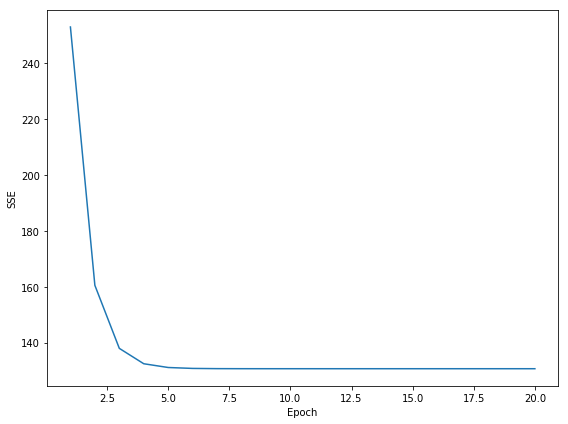

In [16]:
plt.figure(figsize=(8.0, 6.0))

plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()
# plt.savefig('./figures/cost.png', dpi=300)
plt.show()

In [17]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='lightblue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)    
    return 

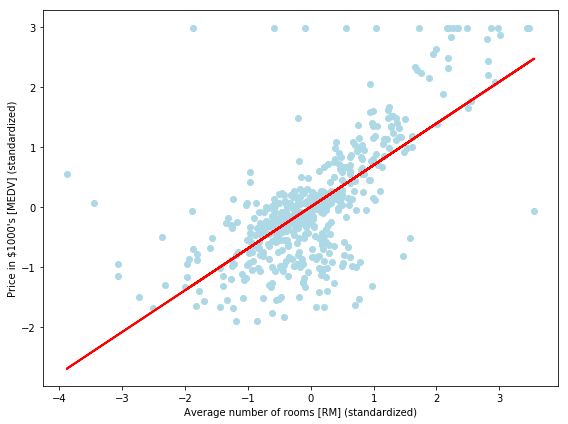

In [18]:
plt.figure(figsize=(8.0, 6.0))

lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.tight_layout()
# plt.savefig('./figures/gradient_fit.png', dpi=300)
plt.show()

In [19]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


In [20]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


<br>
<br>

## 10.3.2 Estimating the coefficient of a regression model via scikit-learn
## 사이킷런을 활용한 회귀 모델 계수 추정

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


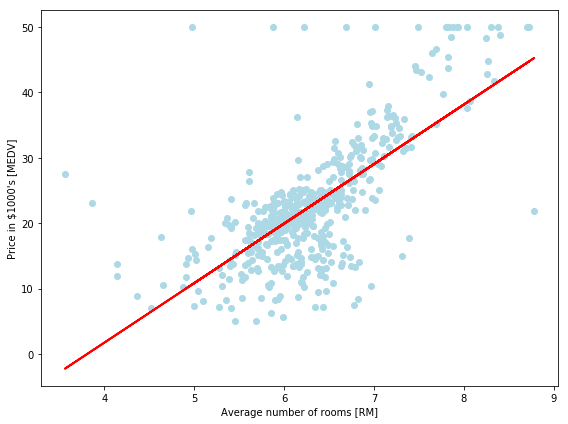

In [23]:
plt.figure(figsize=(8.0, 6.0))

lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()
# plt.savefig('./figures/scikit_lr_fit.png', dpi=300)
plt.show()

**Normal Equations** alternative:

In [24]:
# adding a column vector of "ones"
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print('Slope: %.3f' % w[1])
print('Intercept: %.3f' % w[0])

Slope: 9.102
Intercept: -34.671


In [25]:
num_rooms_std = np.array([[5.0]])
price_std = slr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % price_std)

Price in $1000's: 10.840


<br>
<br>

# 10.4 Fitting a robust regression model using RANSAC
# RANSAC을 사용하는 강건한 회귀 모델 피팅

<pre>
- 선형회귀 모델은 이상치에 강하게 영향 받을 수 있다. 
- 특정 상황에서는 우리 데이터의 아주 작은 일부가 모델의 계수를 추정하는 데 크게 영향을 미칠 수 있다. 
- 이상치를 버리는 방법의 하나로 RANSAC(RANdom SAmple Consensus) 알고리즘을 사용하는, 회귀분석 중 강건한(robust) 메서드를 살펴볼 것이다. 
- 이것은 회귀 모델을 참정보(inliers)라고 하는 일부 데이터에 피팅하는 것이다. 

1. 참정보가 되고 모델을 피팅할 임의의 샘플 수를 선택한다.
2. 피팅한 모델에 나머지 모든 관측치를 테스트하고 사용자가 설정한 참정보의 허용오차 안으로 떨어지는 관측치를 참정보로 추가한다.
3. 모든 참정보를 사용하여 모델을 다시 피팅한다.
4. 피팅된 모델과 참정보 간 오차를 추정한다.
5. 알고리즘의 성능이 사용자 정의의 특정 임계치를 만족하거나, 설정한 반복 횟수에 다다르면 종료한다(그렇지 않으면 1단계로 돌아간다).
</pre>

In [26]:
from sklearn.linear_model import RANSACRegressor

if Version(sklearn_version) < '0.18':
    ransac = RANSACRegressor(LinearRegression(), 
                             max_trials=100, 
                             min_samples=50, 
                             residual_metric=lambda x: np.sum(np.abs(x), axis=1), 
                             residual_threshold=5.0, 
                             random_state=0)
else:
    ransac = RANSACRegressor(LinearRegression(), 
                             max_trials=100, 
                             min_samples=50, 
                             loss='absolute_loss', 
                             residual_threshold=5.0, 
                             random_state=0)

ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_trials=100, min_samples=50, random_state=0,
        residual_metric=None, residual_threshold=5.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

- 기본적으로 사이킷런 사용자들은 MAD 추정을 사용해서 참정보의 임계치를 선택한다. 
- 여기서 MAD는 목표변수 $y$에 대한 중앙절대편차(Median Absolute Deviation)를 나타낸다. 
- 하지만, 참정보 임계치에 적합한 값은 문제에 따라 달라진다는 것이 RANSAC의 한 가지 단점이다. 

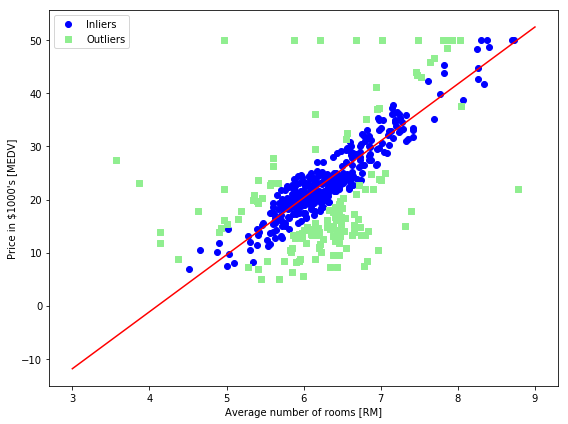

In [27]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

plt.figure(figsize=(8.0, 6.0))

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/ransac_fit.png', dpi=300)
plt.show()

In [28]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


<br>
<br>

# 10.5 Evaluating the performance of linear regression models 
# 선형회귀 모델의 성능 평가 

In [29]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [30]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

- 우리의 모델이 다중 설명변수들을 사용하기 때문에 선형회귀선을(또는 하이퍼플레인이 정확하도록) 시작할 수는 없지만, 그 잔차를(실제의 값과 예측된 값 사이의 차이나 수직 거리) 우리 회귀 모델의 진단을 위한 예측값과 비교하여 플로팅할 수 있다. 
- 이런 잔차 플롯(residual plot)은 일반적으로 비선형성이나 이상치를 확인하고 오차가 랜덤하게 분포되어 있는지 확인함으로써 회귀 모델을 진단하기 위한 그래픽 분석으로 사용한다.

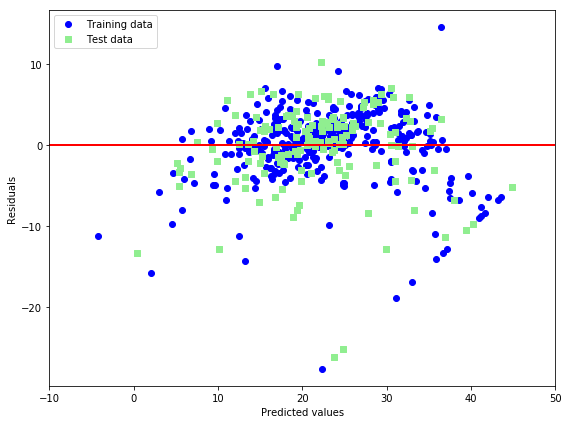

In [31]:
plt.figure(figsize=(8.0, 6.0))

plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

- 예측이 완벽하면 잔차는 정확히 0이 되는데 이것은 아마 실제에서나 응용 시에 절대 마주할 수 없을 것이다.
- 하지만 좋은 회귀 모델이라면 오차는 랜덤하게 분포하고, 잔차는 중심선 주변에 랜덤하게 흩어져 있어야 한다.
- 잔차 플롯을 사용해서 이상치를 감지할 수도 있는데, 이들은 중심선으로부터의 편차가 큰 점들이라고 할 수 있다.

- 모델 성은의 또 다른 유용한 양적 측정 방법은 평균제곱오차(Mean Squared Error, MSE)라고 하는 것인데,
- 선형회귀 모델을 피팅하기 위해 우리가 최소화하는 SSE 비용함수의 평균값이다.
- MSE는 여러 가지 회귀 모델을 비교할 때 혹은 그리드 검색이나 교차 검증을 활용하여 파라미터들을 튜닝할 때 유용하다.

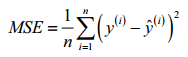

In [32]:
Image(filename='./images/10_22.png', width=200)

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


- 훈련데이터에 대한 MSE와 테스트의 MSE를 보면, 이 모델이 훈련 데이터를 오버피팅하고 있다는 것을 가리킨다.
- 훈력데이터에 대한 $R^2$는 0.765으로 그렇게 나빠 보이지 않지만, 테스트 데이터에 대한 $R^2$은 0.673일뿐이다.
- 때로는 모델 성능에 대한 이해를 돕기 위해 MSE의 표준화 버전으로 이해되는 결정계수$(R^2)$을 보고하는 것이 좀더 유용할 때가 있다.
- 다른 말로 하면 $R^2$는 모델로 감지되는 반응(response) 분산의 일부이다.

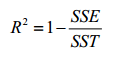

In [34]:
Image(filename='./images/10_23.png', width=150)

- 여기서 SSE는 제곱오차의 합이고 SST는 제곱의 총합이다.
- 혹은 간단히 다른 말로 하면, 반응(response)의 분산이라고 할 수 있다.
- 그리고 $R^2$은 MSE의 재조정된 버전이라고 할 수 있다.

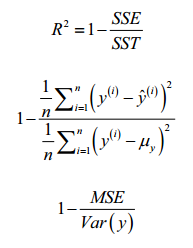

In [35]:
Image(filename='./images/10_24.png', width=200)

- 훈련 데이터에 대해 $R^2$은 0에서 1사이의 값을 갖지만 테스트 데이터에 대해서는 음의 값이 될 수 있다.
- $R^2=1$ 이면 모델은 MSE=0의 값을 가지며 데이터를 완벽하게 피팅한다.

<br>
<br>

# 10.6 Using regularized methods for regression 
# 회귀를 위한 정규화 메서드 사용 

- 정규화는 추가의 정보를 더함으로써 오버피팅 문제를 막을 수 있는 한 가지 방법이다.
- 모델의 파라미터 값을 수축시키는 것으로 복잡도에 대한 벌칙을 부과한다.
- 정규화된 선형회귀로 가장 인기 있는 접근법이 리지회귀(Ridge Regression), 라쏘(Least Absolute Shrinkage and Selection Operator, LASSO)와 엘라스틱 넷(Elastic Net) 메서드이다.

- 리지회귀는 L2 벌칙 모델로 우리의 최소-제곱 비용 함수에 가중치의 제곱합을 더한 것이다.

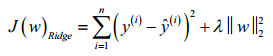

In [36]:
Image(filename='./images/10_25.png', width=300)

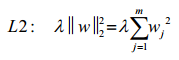

In [37]:
Image(filename='./images/10_26.png', width=200)

- 하이퍼파라미터 $\lambda$의 값을 증가시킴으로써 정규화 강도는 증가되고, 모델의 가중치는 수축된다. 
- 절편 항 $w_0$ 은 정규화하지 않는다는 것에 주의하자. 

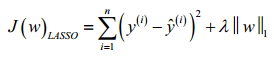

In [38]:
Image(filename='./images/10_27.png', width=300)

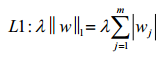

In [39]:
Image(filename='./images/10_28.png', width=200)

- 특정 가중치는 0이 되는 정규화 강도 덕분에 라쏘 역시 지도적 피처 선택 기법으로 유용하다.
- 그러나, 라쏘의 한계는 $m>n$ 인 경우, 기껏해야 $n$개의 변수를 선택한다는 것이다.
- 리지회귀와 라쏘사이의 타협점이 엘라스틱 넷(Elastic Net)이다.
- 이것은 희소성을 생성하기 위한 L1 벌칙과, 선택변수의 개수와 같은 라쏘의 몇 가지 제약을 극복할 수 있는 L2 벌칙을 갖고 있다.

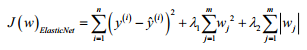

In [40]:
Image(filename='./images/10_29.png', width=400)

- 이런 정규화 회귀 모델은 사이킷런을 통해 모두 사용가능하며 $\lambda$ 파라미터를 사용해서 정규화 강도를 사용자가 설정해야 한다는 것을 제외하고는, k-fold 교차검증을 활용하여 최적화하는 등의 사용법은 정규회귀 모델과 유사하다.

In [41]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
ridge_y_train_pred = ridge.predict(X_train)
ridge_y_test_pred = ridge.predict(X_test)

print(ridge.coef_)

[ -1.20763405e-01   4.47530242e-02   5.54028575e-03   2.51088397e+00
  -1.48003209e+01   3.86927965e+00  -1.14410953e-02  -1.48178154e+00
   2.37723468e-01  -1.11654203e-02  -1.00209493e+00   6.89528729e-03
  -4.87785027e-01]


In [42]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_y_train_pred = lasso.predict(X_train)
lasso_y_test_pred = lasso.predict(X_test)

print(lasso.coef_)

[-0.11311792  0.04725111 -0.03992527  0.96478874 -0.          3.72289616
 -0.02143106 -1.23370405  0.20469    -0.0129439  -0.85269025  0.00795847
 -0.52392362]


In [43]:
from sklearn.linear_model import ElasticNet

elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)
elasticnet.fit(X_train, y_train)
elasticnet_y_train_pred = elasticnet.predict(X_train)
elasticnet_y_test_pred = elasticnet.predict(X_test)

print(lasso.coef_)

[-0.11311792  0.04725111 -0.03992527  0.96478874 -0.          3.72289616
 -0.02143106 -1.23370405  0.20469    -0.0129439  -0.85269025  0.00795847
 -0.52392362]


- ElaticNet은 우리가 L1에서 L2까지의 비율을 변경할 수 있게 해준다.
- 예를 들어 l1_ratio를 1.0으로 설정하면 ElasticNet 리그레서(regressor)는 라쏘회귀과 같아질 것이다.

In [44]:
print('[Ridge]')
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, ridge_y_train_pred),
        mean_squared_error(y_test, ridge_y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, ridge_y_train_pred),
        r2_score(y_test, ridge_y_test_pred)))
print('')

print('[Lasso]')
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, lasso_y_train_pred),
        mean_squared_error(y_test, lasso_y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, lasso_y_train_pred),
        r2_score(y_test, lasso_y_test_pred)))
print('')

print('[ElasticNet]')
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, elasticnet_y_train_pred),
        mean_squared_error(y_test, elasticnet_y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, elasticnet_y_train_pred),
        r2_score(y_test, elasticnet_y_test_pred)))
print('')

[Ridge]
MSE train: 19.964, test: 27.266
R^2 train: 0.764, test: 0.673

[Lasso]
MSE train: 20.926, test: 28.876
R^2 train: 0.753, test: 0.653

[ElasticNet]
MSE train: 21.049, test: 28.945
R^2 train: 0.752, test: 0.652



<br>
<br>

# 10.7 Turning a linear regression model into a curve - polynomial regression 
# 선형회귀 모델을 곡선의 다항 회귀로 변환하기 

- 선형성에 관한 가정 위반을 설명할 수 있는 한 가지 방법은 다항항을 추가하여 다항회귀를 사용하는 것이다. 

\begin{equation*}
y=w_0+w_1x+w_2x^2x^2+...+w_dx^d
\end{equation*}

- 여기서 $d$는 다항의 차수를 나타낸다.
- 우리가 다항회귀를 사용하여 비선형관계를 모델링할 수 있다 하더라도 여전히 선형회귀 계수 $w$ 때문에 다중 선형회귀 모델을 고려해야 한다.

- 사이킷런에서 PolynomialFeatures 변형기 클래스를 사용하여 하나의 설명변수를 갖는 심플회귀 문제에 2차 항($d=2$)를 더한 다음 선형 피팅과 이 다항을 비교하는 방법에 대해 논의할 것이다.

In [45]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [46]:
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

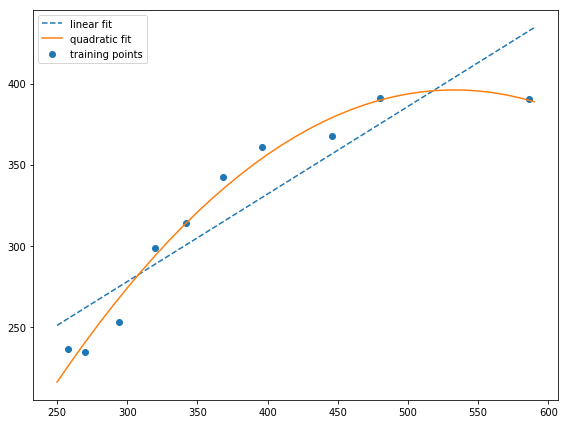

In [47]:
plt.figure(figsize=(8.0, 6.0))

# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/poly_example.png', dpi=300)
plt.show()

In [48]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [49]:
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


- MES는 570에서(선형 피팅) 61로(2차 피팅) 떨어졌고, 결정계수는 선형 피팅($R^2=0.832$)과는 대조적으로 2차 모델에($R^2=0.982$) 좀 더 잘 피팅되어 있다.

<br>
<br>

## 10.7.1 Modeling nonlinear relationships in the Housing Dataset 
## 하우징 데이터 내의 비선형관계 모델링 

- 2차 다항식과 3차 다항식을 사용하는 LSTAT(더 낮은 인구 상태)과 집 가격 간의 관계를 모델링하고 그 모델을 선형 적합과 비교할 것이다.

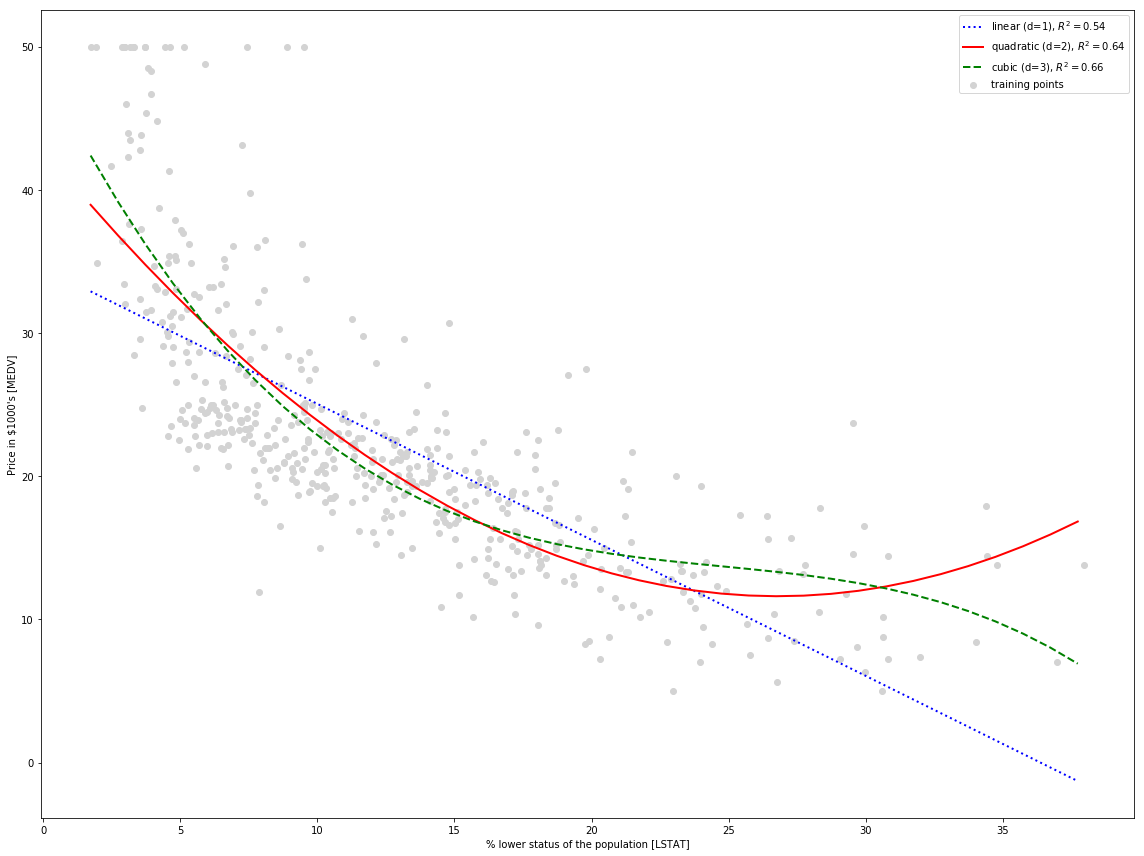

In [57]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.figure(figsize=(16.0, 12.0))

plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('./figures/polyhouse_example.png', dpi=300)
plt.show()

- 정육면체로 피팅한 경우가 하우스 가격과 LSTAT 간의 관계를 선형피팅이나 2차 피팅보다 잘 감지한다.
- 하지만 더 많은 다항 피처를 추가할수록 모델의 복잡도가 증가하고 오버피팅이 발생할 수 있는 경우가 증가하게 된다.
- 실제로는 일반화 성능을 추정하기 위해 언제나 분리된 테스트 데이터에서 모델 성능을 평가하기를 추천한다.

- 다항 피처들이 언제나 비선형관계 모델링을 위한 최선의 선택은 아니다.
- 예를 들어, MEDV-LSTAT 산점도를 보고 LSTAT 피처 변수의 로그 변형과 MEDV의 제곱근은 데이터를 선형회귀 적합에 맞게 선형 피처 공간에 투영하는 것을 제안할 수 있을 것이다.

Transforming the dataset:

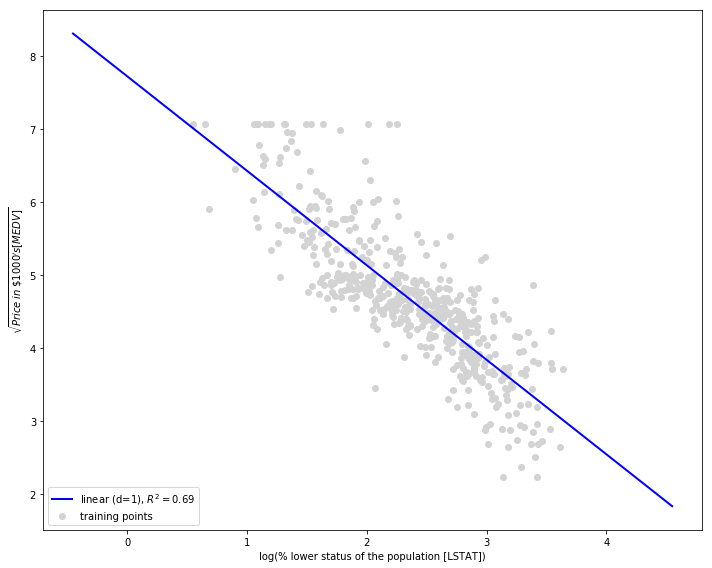

In [58]:
X = df[['LSTAT']].values
y = df['MEDV'].values

# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.figure(figsize=(10.0, 8.0))

plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')

plt.tight_layout()
# plt.savefig('./figures/transform_example.png', dpi=300)
plt.show()

- 설명변수들을 로그 공간으로 변형하고 목표변수의 제곱근을 사용함을써, 이전의 다른 다항 특성 변환보다 데이터를 잘 피팅시키는($R^2=0.69$) 것으로 보이는 선형회귀선을 갖는 두 개 변수 간의 관계를 포착할 수 있었다.

<br>
<br>

# 10.7.2 Dealing with nonlinear relationships using random forests
# 랜덤 포레스트를 사용하여 비선형관계 처리하기 

- 랜덤 포레스트는 다중 의사결정나무의 앙상블로 다른 전역 선형이나 다항회귀 모델과는 대조적인 조각별 선형함수의 합으로 이해된다.
- 의사결정나무 알고리즘을 활용하여 입력 공간을 좀 더 관리하기 쉽도록 더 작은 영역으로 부분 분할한다는 것이다.

## 10.7.2.1 Decision tree regression 
## 의사결정나무 회귀 

- 의사결정나무 알고리즘의 장점은 사용자가 비선형 데이터를 처리할 때 어떤 식으로든 피처를 변형할 필요가 없다는 것이다.
- 의사결정나뭉의 노드를 잎(leaf)이 순수해지거나 멈춤 조건으로 만족할 때까지 반복하여 노드를 분기함으로써 나무가 자라게 된다.
- 분류를 위해 의사결정나무를 사용했을 때 피처가 인포메이션 게임(IG, Information Gain)을 최대화하는지 결정하기 위한 불순동의 측정 기준으로 엔트로피(entropy)를 정의했었다.

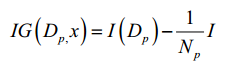

In [60]:
Image(filename='./images/10_30.png', width=200)

- $x$는 분기를 수행하기 위한 피처이며, $N_p$는 부모 노등에 있는 샘플의 개수이다.
- $I$는 불순도 함수이며 $D_p$는 부모 노드에 있는 훈련 샘플의 일부이다.
- 그리고 $D$는 분기 후 왼쪽과 오른쪽 자식 노드에 있는 훈련 데이터의 일부부들이다.
- 우리의 목표는 인포메이션 게인을 최대화하는 피처들의 분기를 찾는 것이다.
- 다른 말로 하면, 우리는 자식 노드 내의 불순도를 줄이는 피처의 분기를 찾고자 하는 것이다.
- 회귀에 대해 의사결정나무를 사용하기 위해 노드 $t$의 불순도 측정기준을 엔트로피(entropy)에서 MSE로 대체할 것이다.

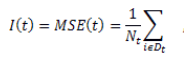

In [67]:
Image(filename='./images/10_31.png', width=210)

- $N_t$는 노드 $t$에서의 훈련 샘픔의 개수이고 $D_t$는 노드 $t$에서의 훈련용 부분 데이터이며 $y^(i)$는 진짜 목표값, 그리고 $\hat{y_t}$는 예측된 목표값(샘플평균)이다.

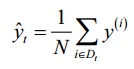

In [66]:
Image(filename='./images/10_32.png', width=150)

- 의사결정 회귀 컨텍스트에서 MSE는 노드-내부의 분포를 참고한다고 되어 있는데 이것은 분기 기준이 분산감소(variance reduction)로 더 잘 알려져 있는 이유이다. 

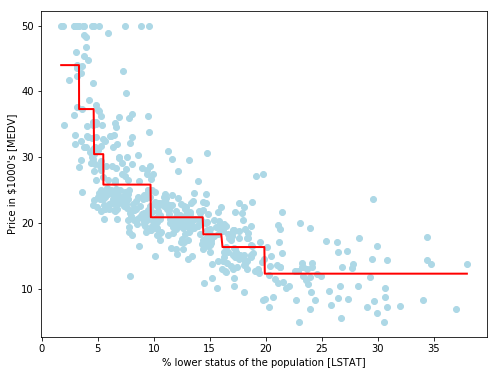

In [52]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

plt.figure(figsize=(8.0, 6.0))

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
# plt.savefig('./figures/tree_regression.png', dpi=300)
plt.show()

- 의사결정나무는 데이터 냉의 일반적인 경향을 잡아낸다.
- 하지만 이 모델은 원하는 예측에 대한 식별 가능성이나 연속성을 포착하지 못한다는 한계가 있다.
- 그리고 데이터가 오버핏(overfit)되거나 언더핏(underift)되지 않게 나무의 깊이를 적당한 값으로 선택할 수 있도록 주의해야한다.
- 여기서는 3 정도의 깊이면 잘 선택한 것으로 보인다.

<br>
<br>

## 10.7.2.2 Random forest regression 
## 랜덤 포레스트 회귀 

- 랜덤 포레스트 알고리즘은 여러 갱의 의사결정나무를 결합하는 앙상블 기법의 하나이다.
- 랜덤 포레스트는 모델의 분산을 감소시키는 데 도움을 주는 임의적인 특성 덕분에 하나의 의사결정나무보다 보통 더 좋은 일반화 성능을 갖는다.
- 또 다른 장점은 데이터 냉의 이상치에 덜 민감해서 파라미터 튜닝이 많이 필요하지 않다는 것이다.
- 일반적으로 랜덤 포레스트의 파라미터는 오직 앙상블 내에서 실험해 볼 나무의 개수뿐이다.
- 회귀에 대한 기본적인 랜덤 포레스트 알고리즘은 분류를 위한 랜덤 포레스트 알고리즘과 거의 동일하다.
- 오로지 차이점은 개별 의사결정나무를 키우기 위해 MSE 설정을 사용한다는 것이고, 예측된 목표변수는 모든 의사결정나무에 대한 평균 예측으로 계산된다는 것이다.

In [71]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

In [72]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


- 이 랜덤 포레스트는 훈련 데이터를 오버핏하는 경향이 있다는 것을 알 수 있다.
- 여전희 설명변수들 간의 관계를 상대적으로 잘 설명하고 있다(테스트 데이터에 대해 $R^2=0.871$).

- $R^2$ 계수에 관해 요약했던 내용에 의하면 $y$축 방향의 이상치는 모델이 테스트 데이터보다 훈련 데이터에 잘 피팅된다는 것을 알 수 있게 해준다.
- 또한 잔차의 분포는 가운데 0점 주변으로 완전하게 랜덤하지 않은 것이 보인다.
- 이것은 모델이 모든 설명 정보를 탐지하지 못함을 의미한다.
- 하지만 이 잔차 플롯은 선형 모델의 잔차 플롯과 비교해 보면 크게 향상되었음을 알 수 있다.

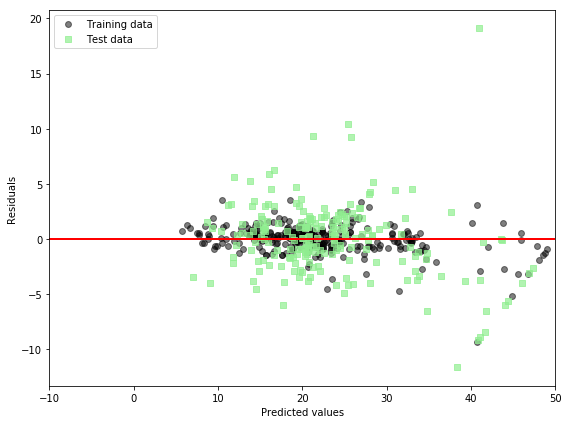

In [77]:
plt.figure(figsize=(8.0, 6.0))

plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='black', 
            marker='o', 
            s=35,
            alpha=0.5,
            label='Training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='lightgreen', 
            marker='s', 
            s=35,
            alpha=0.7,
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

<br>
<br>

# 10.8 Summary

- 하나의 설명변수와 연속형 방응변수 간의 관계를 모델링하는 심플 선형회귀 모델의 사용에 대해 학습했다. 
- 데이터 내의 패턴과 이상치를 살펴보는 데 유용한 데이터 분석 기법에 대해 논의했다. 이것이 예측 모델링 작업에서 중요한 첫 번째 단계이다. 
- 첫 번째 모델은 그래디언트 기반의 최적화 방법을 사용하는 선형회귀를 구현하여 만들었다. 
- 회귀 모델에 대한 사이킷런 선형 모델을 활용하는 방법을 살펴보고 이상치를 처리하기 위한 한 가지 방법으로 RANSAC을 구현하기도 했다. 
- 회귀 모델의 예측 성능을 평가하기 위해 제곱 오차의 평균합과 이와 관련된 $R^2$을 계산했다. 
- 정규화를 회귀 모델에 적용하여 모델의 복잡도를 줄이고 오버피팅을 피하는 방법에 대해 논의했다. 
- 다항 특성 변환과 랜덤 포레스트 리그레서를 포함하여 비선형관계를 모델링하기 위한 여러 가지 방법도 소개했다. 